In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import numpy.random as nrand
import scipy.stats as stats

In [121]:
AF_dict = {}

for N_gen in range(80000,110001,10):
    print(N_gen,flush=True,end='\r')
    
    tmp_df = pd.read_table(
        f'SLiM/Simulation_log/env20_AF_dynamics/env20_{N_gen}.txt',
        header = None,
        delim_whitespace = True
    )

    tmp_df = tmp_df[[4,7,10,11]].rename({4:'ID',7:'s',10:'SG',11:'AF'},axis=1)
    
    for i, row in tmp_df.iterrows():
        ID = row['ID']
        if (ID in AF_dict) and (row['AF'] < 20000):
            AF_dict[ID]['AF'].append(row['AF'])
            AF_dict[ID]['s'].append(row['s'])
            AF_dict[ID]['EG'] = N_gen
        elif row['AF'] < 20000:
            AF_dict[ID]={'AF':[row['AF']],'SG':row['SG'],'EG':N_gen,'s':[row['s']]}

In [122]:
# with open('SLiM/Simulation_log/env20_AF_dynamics.pkl','wb') as f:
#     pkl.dump(AF_dict,f)

In [23]:
with open('SLiM/code/Simulation_log/pop10000_AF_dynamics.pkl','rb') as f:
    AF_dict = pkl.load(f)

In [105]:
# for key, item in AF_dict.items():
#     if (np.max(item['AF']) > 10000) and (np.abs(item['s']) > 0.005) and (np.abs(item['s']) > 0.00005) \
#     and (item['SG']>81000):
#         print(key)
#         print(item['s'])

In [40]:
rcParams_dict = {
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

26427231.0
33683783.0


/tmp/ipykernel_95294/1563878958.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels((np.linspace(80000,110000,7)).astype(int))


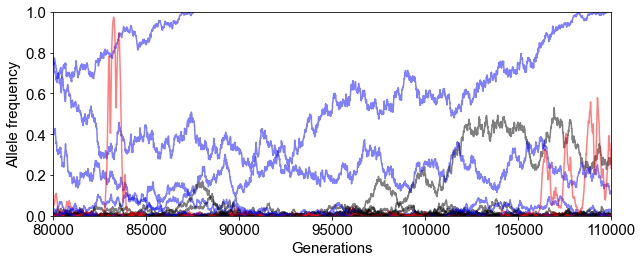

In [179]:
Ne = 10000
id_list = list(AF_dict.keys())
i=0
nrand.seed(30) #Neutral:13,Quasi20:30,pop10000:22
id_sub_list = nrand.choice(id_list,50000,replace=False)
#id_sub_list = np.append(id_sub_list,[29088945.0]) # for quasi_env10 model
id_sub_list = np.append(id_sub_list,[26427231.0,33683783.0]) # for quasi_env20 model
#id_sub_list = np.append(id_sub_list,[27842930.0,31294446.0]) # for pop10000
N_neutral_lines = 0
N_nonneutral_lines = 0

fig,axes = plt.subplots(figsize=[10,3.75],facecolor='w')
ax1 = axes
for _id in id_sub_list:
    item = AF_dict[_id]
    
    if item['EG'] - item['SG'] < 200:
        continue
    if np.abs(item['s']).mean() <= 0:
        c = 'b'; a=0.5
    elif np.abs(item['s']).mean() < 0.005:
        c = 'k'; a = 0.5
    else:
        c = 'r'; a=0.5;
        if max(item['AF'])>4000:
            print(_id)
        
    ax1.plot(
        range(max(80000,int(item['SG'])),int(item['EG'])+1,10),item['AF'],
        color = c,
        alpha = a
    )
    
ax1.set_ylim(0,20000)
ax1.set_xlim(80000,110000)
ax1.set_yticks(np.linspace(0,20000,6))
ax1.set_yticklabels(np.linspace(0,10,6)/10)
ax1.set_ylabel('Allele frequency')
ax1.set_xlabel('Generations')
ax1.set_xticklabels((np.linspace(80000,110000,7)).astype(int))
#plt.savefig('./Figures/Fig3_3.pdf')
# ax2.set_ylim(0,300)
# ax2.set_xlim(sub_range_s,sub_range_e)

In [180]:
sim_df_dict = {} 
for version in ['Neutral','quasi_pop10000','quasi_env20']:
    sim_df_dict[version] = pd.read_csv(f'SLiM/Simulation_log/sim_summary_{version}.txt')

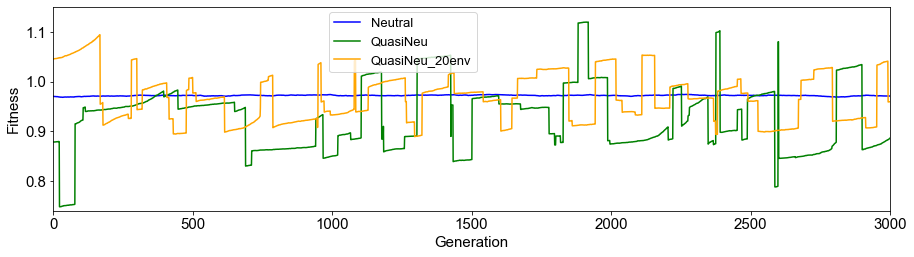

In [202]:
color_list = ['blue','green','orange']
label_list = ['Neutral','QuasiNeu','QuasiNeu_20env']
plt.subplots(figsize=[15,3.75],facecolor='w')
for i,version in enumerate(['Neutral','quasi_pop10000','quasi_env20']):
    plt.plot(sim_df_dict[version]['Mean_fitness'],label=label_list[i],color=color_list[i])
plt.xlim(10000,13000)
plt.xticks(range(10000,13001,500),range(0,3001,500))
#plt.ylim(0.88,1.13)
plt.ylim(0.74,1.15)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.legend(fontsize=13,loc=[0.33,0.68])
#plt.savefig('./Figures/Fig3d.pdf')

In [192]:
env_change_dict = {}
for version in ['quasi_pop10000','quasi_env20']:
    env_change_list = []
    sim_df = pd.read_csv(f'./SLiM/Simulation_log/sim_summary_{version}.txt')
    p_env = -1
    for i,row in sim_df.iterrows():
        if row['env_idx'] != p_env:
            env_change_list.append(row['generation'])
            p_env = row['env_idx']
    env_change_dict[version] = env_change_list

In [207]:
Gen_pointer-80000

29968.0

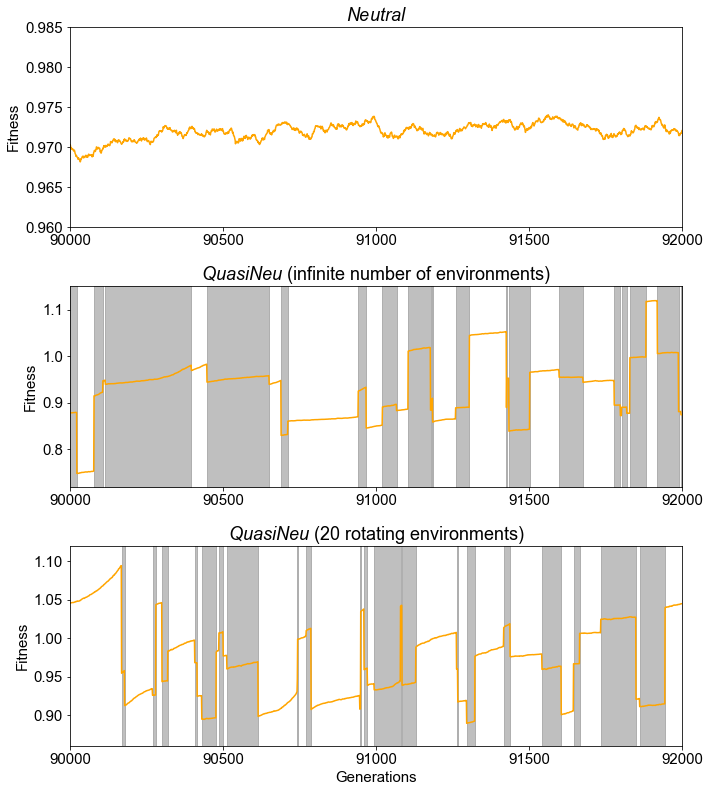

In [215]:
color_list = ['orange','orange','orange']
title_list = ['$\mathit{Neutral}$','$\mathit{QuasiNeu}$ (infinite number of environments)','$\mathit{QuasiNeu}$ (20 rotating environments)']
fig,axes = plt.subplots(3,1,figsize=[10,11.25],facecolor='w')
for i,version in enumerate(['Neutral','quasi_pop10000','quasi_env20']):
    ax = axes[i]
    ax.plot(sim_df_dict[version]['Mean_fitness'],color=color_list[i])
    # draw grey shades
    if version != 'Neutral':
        Gen_pointer = -1
        if version == 'quasi_pop10000':
            Gen_pointer = 90000
        for Gen_idx in env_change_dict[version]:
            if Gen_idx > 90000:
                if Gen_pointer == -1:
                    Gen_pointer = Gen_idx
                else:
                    ax.fill_between([Gen_pointer-80000,Gen_idx-80000], 0, 1.5, alpha=0.5,color='grey')
                    Gen_pointer = -1
            elif Gen_idx > 92000:
                break
                    
    ax.set_xlim(10000,12000)
    ax.set_xticks(range(10000,12001,500))
    ax.set_xticklabels(range(90000,92001,500))
    if version == 'Neutral':
        ax.set_ylim(0.96,0.985)
    elif version == 'quasi_pop10000':
        ax.set_ylim(0.72,1.15)
    elif version == 'quasi_env20':
        ax.set_ylim(0.86,1.12)
    ax.set_ylabel('Fitness')
    if i == 2:
        ax.set_xlabel('Generations')
    #ax.legend(loc='upper right')
    ax.set_title(title_list[i])
plt.tight_layout()
#plt.savefig('./Figures/Fig3d_separate.pdf')